# Kaggle + colab 연동해보기

In [ ]:
!pip install torchsummary

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"starryboram","key":"64c20dd5b68c8fda7b61e5b4229357a0"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:08<00:00, 33.5MB/s]
100% 2.29G/2.29G [01:08<00:00, 35.9MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

In [ ]:
!ls  # 데이터가 다운로드 되면 !IS를 통해서 다운로드 된 모든 파일의 이름을 볼수있다.

chest_xray  chest-xray-pneumonia.zip  drive  kaggle.json  sample_data


# ★ 여기부터

In [ ]:
import torch
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함힘
import torch.nn.init as init # 텐서에 초기값을 줌

import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

# 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import glob
from PIL import Image
import cv2
from torchsummary import summary

In [ ]:
!nvidia-smi

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

## 데이터 불러오기

In [ ]:
data_dir="/content/chest_xray"

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize([256,256]),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

test_trainsform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize([256,256]),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

In [ ]:
trainset=datasets.ImageFolder(data_dir + "/train/", transform=train_transform)
testset=datasets.ImageFolder(data_dir + "/test/",transform=test_trainsform)
valid=datasets.ImageFolder(data_dir + "/val/",transform=test_trainsform)

In [ ]:
print(type(trainset), type(testset), type(valid))
print(len(trainset), len(testset), len(valid))

In [ ]:
dataset_size = len(trainset)
train_size = int(dataset_size * 0.8)
valid_size = int(dataset_size-train_size)

In [ ]:
trainset, validset = random_split(trainset, [train_size, valid_size])

In [ ]:
validset=valid+validset

In [ ]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(testset), len(testset))

In [ ]:
type(trainset[0][0]), type(trainset[0][1])

In [ ]:
trainset[0][0].size()

# 데이터 시각화

In [ ]:
img = trainset[524][0]
plt.imshow(img.permute(1, 2, 0))
print(trainset[524][1]) # label 0 = 폐렴 아님

In [ ]:
img = trainset[39][0]
plt.imshow(img.permute(1, 2, 0))
print(trainset[39][1]) # label 1 = 폐렴

NameError: ignored

In [ ]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=8)
for i in range(8):
  # axes[i].imshow(trainset[i][0].permute(1, 2, 0))
    img = trainset[i][0]
    print(trainset[i][1])
#img = img * 0.5 + 0.5 # unnormalize (normalize : (data - 0.5)/0.5))
    axes[i].imshow(img.permute(1, 2, 0))

In [ ]:
labels_map = {0 : 'normal', 1 : 'pneumonia'}

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 5

for i in range(1,columns*rows +1):
  rnd_idx = np.random.randint(len(trainset))
  img = trainset[rnd_idx][0].permute(1, 2, 0) 
  # img = img * 0.5 + 0.5 # unnormalize (normalize : (data - 0.5)/0.5))
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
  # 정답 :trainset[rnd_idx][1] - 정수
  plt.title(labels_map[trainset[rnd_idx][1]])
  plt.axis("off")


# 데이터 적재

In [ ]:
# 파이토치는 데이터를 셔플하거나, 병렬로 데이터를 부르거나,혹은 배치 작업을 
# torch.utils.data.DataLoader 를 통해서 도와줌
batch_size = 16 # 중요한 하이퍼 파라미터, 16 이하로 사용하는것이 성능에 좋다고 알려져 있음
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [ ]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(trainloader)
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

# model compile, optimizer

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # 손실함수
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # 옵티마이저 : Momentum
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) # 규제의 강도 : weight_decay=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# monitoring 하고 있는 값(test_loss)이 patience 기간동안(onPlateau) 줄어들지 않을때  lr에 factor(0.1)를 곱해줌
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=7, factor=0.1, verbose=True)

# 모델 생성 (googlenet)

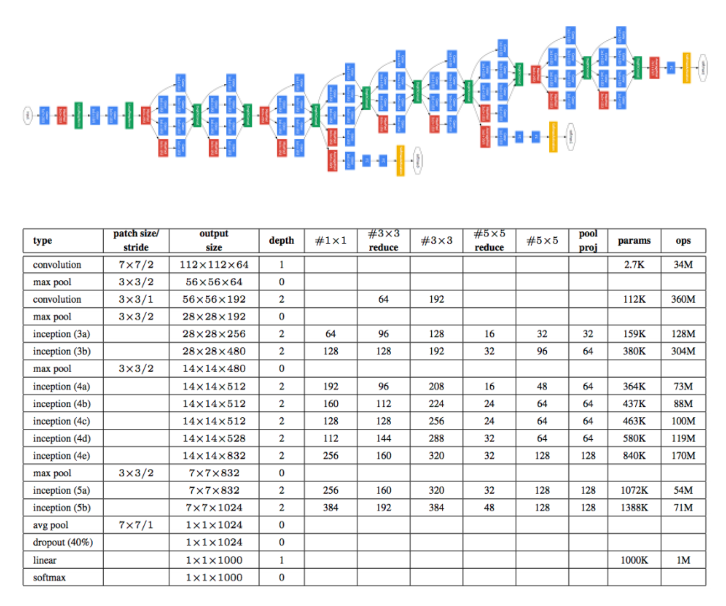

In [ ]:
######################### convolution block 쌓기##########################################

def conv_1(in_dim,out_dim): # 1*1
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

def conv_1_3(in_dim,mid_dim,out_dim): # 1*1 -> 3*3
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model

def conv_1_5(in_dim,mid_dim,out_dim): # 1*1 -> 5-5
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

def max_3_1(in_dim,out_dim): # 3*3 maxpooling -> 1*1
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

######################### Inception Module 정의###################################

class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

######################### googlenet 정의###################################

class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [ ]:
model = GoogLeNet()
model.to(device) # model을 GPU로 보내기
print(model)

In [ ]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

# 모델 훈련

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
def validation(model, testloader, criterion):
#     test_accuracy = 0
    test_loss = 0
    preds_list=[]
    true_list=[]
    
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()
            probs = F.softmax(logits.cpu(), dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
#             correct = (preds == labels).sum()
#             accuracy = correct / images.shape[0]
#             test_accuracy += accuracy
   
            labels=labels.cpu()
            preds_list.extend(preds)
            true_list.extend(labels)
        # 평가지표 계산    
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        
                
    return val_accuracy, val_recall, val_f1_score, test_loss

In [ ]:
def train(model, epochs, criterion, optimizer):
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(trainloader) 
    print_every = iter_per_epoch
    best_f1_score = 0.7
    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = 8 # monitoring 하는 test loss가 더이상 줄지 않는 횟수를 몇번이나 참을지..
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader): #iterator에서 batch_size씩 가져와 images와 labels에 전달
            steps += 1
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # not Flatten!!
            # images.resize_(images.size()[0], 784)
            optimizer.zero_grad()
            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)
            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()
            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step() 
            train_loss += loss.item() # 1 epoch 당 누적된 로스
            if steps % print_every == 0 : 
                model.eval() # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                val_accuracy, val_recall, val_f1_score, val_loss = validation(model, validloader, criterion)
                train_accuracy, train_recall, train_f1_score, train_loss = validation(model, trainloader, criterion)
                # writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                # writer.add_scalar("Loss/test", valid_loss/len(validloader), epoch)
                # writer.add_scalars("Loss/train and valid",
                #                   { "train" : train_loss/len(trainloader),
                #                     "test" : valid_loss/len(validloader) }, epoch)
                print("Epoch : {}/{}...".format(epoch+1, epochs),
                      " Valid Recall : {:.3f}".format(val_recall),
                      " Valid Accuracy : {:.3f}".format(val_accuracy),
                      " Valid F1_score : {:.3f}".format(val_f1_score),
                      " Train Recall : {:.3f}".format(train_recall),
                      " Train Accuracy : {:.3f}".format(train_accuracy),
                      " Train F1_score : {:.3f}".format(train_f1_score)
                     )
                # Best model 저장
                if val_f1_score > best_f1_score:
                    torch.save(model.state_dict(), "best_checkpoint.pth")
                    best_f1_score = val_f1_score
                # Early stopping Start 
                if val_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        # writer.flush() 
                        return
                else: 
                    min_loss = val_loss
                    trigger = 0
                    # print("min loss set to current valid loss!!!")
                # Early stopping End
                train_loss = 0
                model.train()
                # Learning Rate Scheduler 
                scheduler.step(val_loss)
    # writer.flush()  

In [ ]:
train(model, 30, criterion, optimizer)

# 평가

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
def evaluate(model, testloader, criterion):
#     test_accuracy = 0
    test_loss = 0
    preds_list=[]
    true_list=[]
    
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()
            probs = F.softmax(logits.cpu(), dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
#             correct = (preds == labels).sum()
#             accuracy = correct / images.shape[0]
#             test_accuracy += accuracy
   
            labels=labels.cpu()
            preds_list.extend(preds)
            true_list.extend(labels)
        # 평가지표 계산    
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        
                
    print("val_accuracy : ", val_accuracy)
    print("val_recall : ", val_recall)
    print("val_f1_score : ", val_f1_score)

In [ ]:
evaluate(model, testloader)

In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), "last_checkpoint.pth")
state_dict = torch.load("last_checkpoint.pth") 
last_model = model.to(device)
 # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
evaluate(last_model, testloader)

In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
#torch.save(model.state_dict(), "last_checkpoint.pth")
#state_dict = torch.load("last_checkpoint.pth") 
#last_model = ResNet(BottleNeck, [3, 4, 6, 3]) # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
#last_model.to(device)
##last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
#evaluate(last_model, testloader)

# f1 함수 설정(미실행)

※ 혹시 모를 상황을 대비해서 적어 놓은 코드

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

# GPU on/off(미실행)

※ 혹시 모를 상황을 대비해서 적어 놓은 코드

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)